# PRÁCTICA ML 101 - GUILLERMO PEDERNAL

Imports:

In [77]:
import numpy  as np  
import pandas as pd
import seaborn as sns
import graphviz

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

### PROBLEMA 1

Problema de clasificación:

    Ingresos > 50000$ / Ingresos < 50000$ 
    Datos: census.csv

Lo primero es cargar los datos para poder analizarlos (análisis exploratorio)

In [8]:
data1 = pd.read_csv("./census.csv")

print("N, D:",data1.shape)
data1.head(5) 

('N, D:', (45222, 14))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [9]:
data1['income'].value_counts()/data1.shape[0] 

<=50K    0.752156
>50K     0.247844
Name: income, dtype: float64

Como era esperable, la variable target está descompensada (los salarios por debajo de los 50000 $ son mucho más comunes que los salarios por encima).

In [4]:
data1.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Con el análisis de la descripción de los campos numéricos se intuyen irregularidades en 3 de ellos. 

- En las dos columnas relacionadas con el capital (ganancias y pérdidas) llaman la atención los cuartiles, parecen indicar que son campos en la que la gran mayoría de las registros son 0. 
- En la columna de horas por semana parece bastante probable que existan outlayers observando los valores mínimo y máximo (no parece que tenga mucho sentido un trabajo de 1 hora a la semana como tampoco lo tiene uno de 99 horas).

Hay una serie de variables que no son de tipo numérico y por lo tanto deberemos codificarlas

In [5]:
le = LabelEncoder()

data1['workclass'] = le.fit_transform(data1['workclass'])
data1['education_level'] = le.fit_transform(data1['education_level'])
data1['marital-status'] = le.fit_transform(data1['marital-status'])
data1['occupation'] = le.fit_transform(data1['occupation'])
data1['relationship'] = le.fit_transform(data1['relationship'])
data1['race'] = le.fit_transform(data1['race'])
data1['sex'] = le.fit_transform(data1['sex'])
data1['native-country'] = le.fit_transform(data1['native-country'])
data1['income'] = le.fit_transform(data1['income'])

data1.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,9,13.0,4,0,1,4,1,2174.0,0.0,40.0,38,0
1,50,4,9,13.0,2,3,0,4,1,0.0,0.0,13.0,38,0
2,38,2,11,9.0,0,5,1,4,1,0.0,0.0,40.0,38,0
3,53,2,1,7.0,2,5,0,2,1,0.0,0.0,40.0,38,0
4,28,2,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4,0


Analizamos ahora de forma gráfica representando los histogramas de cada variable.

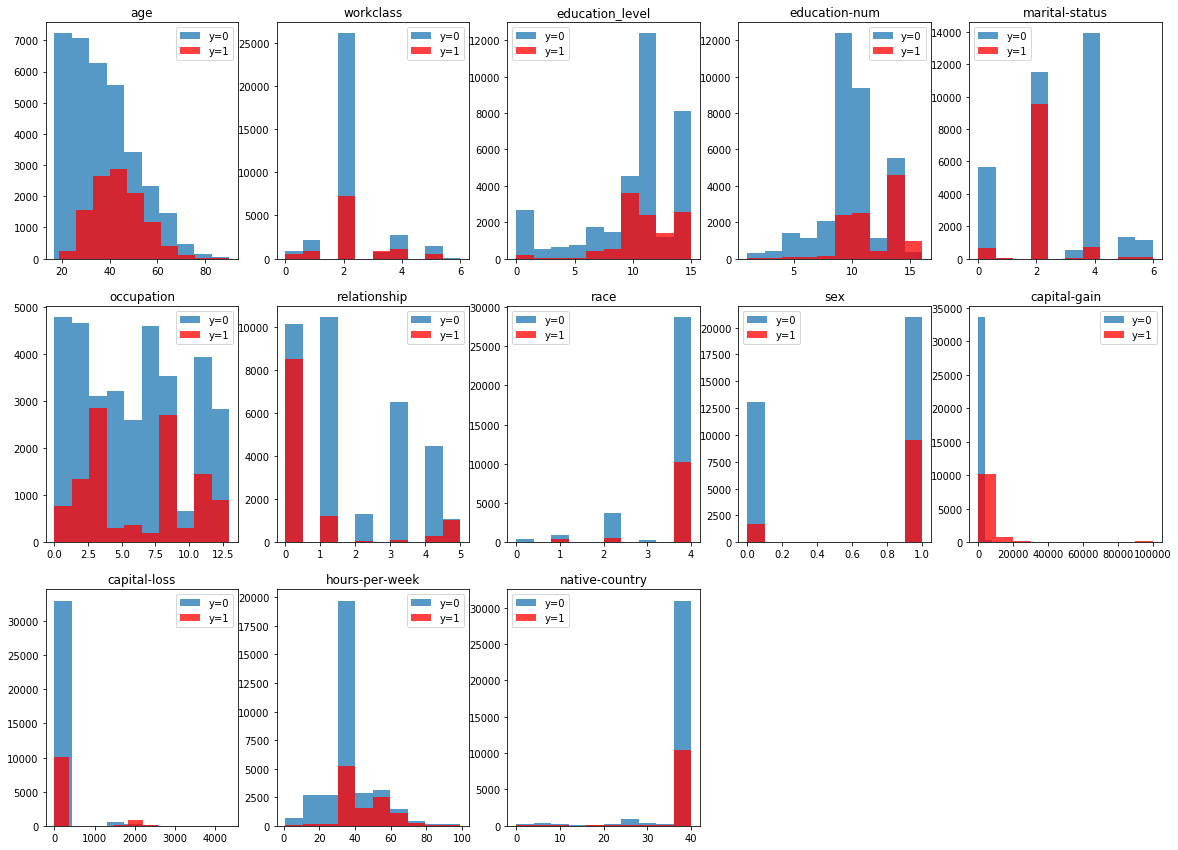

In [6]:
plt.figure(figsize=(20,20))

idx_0 =  data1['income'] == 0
idx_1 =  data1['income'] == 1

for i, feature in enumerate(data1.columns.drop(['income'])):
    plt.subplot(4,5,i+1)
    plt.hist(data1.ix[idx_0,feature],normed=0,alpha=0.75,label='y=0')
    plt.hist(data1.ix[idx_1,feature],normed=0,facecolor='red',alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)
    
plt.show()

A simple vista parece que en el caso de algunas variables, casi todas las muestras de salarios por encima de los 50000$ se aglutinan entorno a un valor. Es el caso de la clase de trabajo, el estado matrimonial y relación (habrá que analizar una posible correlación excesiva entre estas dos), raza, sexo y país.
Además confirmamos que las variables relacionadas con el capital son mayoritariamente 0 y por lo tanto es probable que se trate de una característica que no nos resultará de mucha ayuda a la hora de clasificar por la variable target.

A continuación examinamos la correlación entre variables.

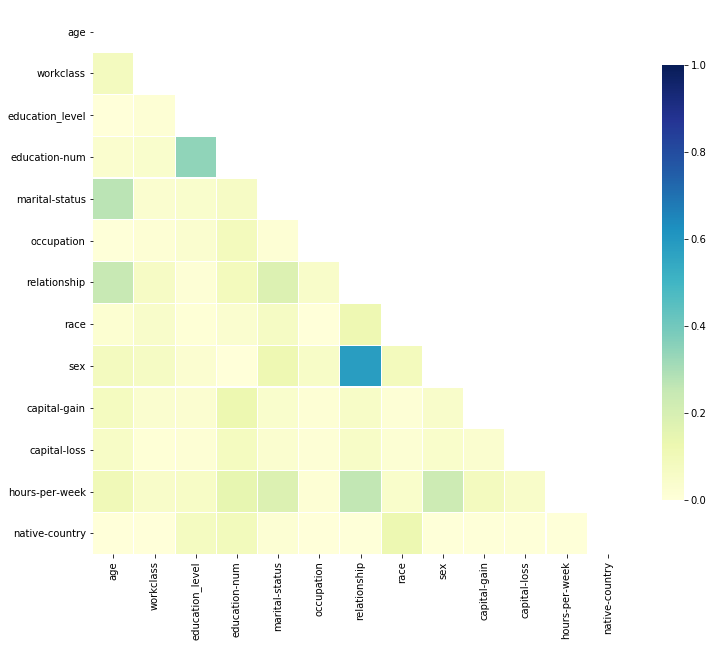

In [7]:
# Compute the correlation matrix
corr = np.abs(data1.drop(['income'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

No existe mucha correlación entre ninguna de las variables, siendo las más correladas 'sex' y 'relationship' con un valor lejano a la unidad por lo que no eliminaremos campos por estar muy correlados.

Vamos a probar en primer lugar con un modelo sencillo tal y como sugiere el resultado para, en caso de que los resultados no sean satisfactorios ir aumentando la complejidad.

Para ello utilizaremos un modelo de regresión logística:

In [8]:
# convertimos el DataFrame al formato necesario para scikit-learn
dataM1 = data1.as_matrix() 

y = dataM1[:,13]
X = dataM1[:,:13]

feature_names = data1.columns[:13]

In [9]:
# Dividimos los datos en entrenamiento y test (75 training, 25 test)
# Utilizo strtify para que los dos conjuntos tengan la misma proporción de mayores y menores de 50000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify = y, random_state = 0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Proporcion train:%0.3f'%np.mean(y_train))
print('Proporcion test: %0.3f'%np.mean(y_test))

('Datos train: ', (33916, 13))
('Datos test:  ', (11306, 13))
Proporcion train:0.248
Proporcion test: 0.248


Utilizamos validación cruzada para encontrar el valor óptimo del parámetro libre, en este caso el coste C.

La muestra esta descompensada (muchas más observaciones con sueldo inferior a 50.000 dólares que superior) de modo que utilizaremos class weight y f1.


best mean cross-validation score: 0.618
best parameters: {'C': 1.2742749857031321}
test-set score: 0.62


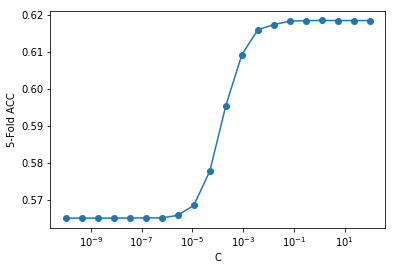

In [10]:
vectorC = np.logspace(-10, 2, 20)
param_grid = {'C': vectorC}
grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'), scoring= 'f1', param_grid=param_grid, cv = 5)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.2f}".format(grid.score(Xs_test, y_test)))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(vectorC,scores,'-o')
plt.xlabel('C')
plt.ylabel('5-Fold ACC')
plt.show()

In [11]:
grid.best_params_['C']

1.2742749857031321

In [12]:
lr = LogisticRegression(C=grid.best_params_['C']).fit(Xs_train,y_train)
y_pred=lr.predict(Xs_train)

Vamos a ver como funciona el modelo con las métricas y la matriz de confusión.

In [13]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

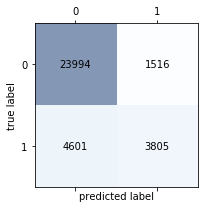

In [14]:
confmat = confusion_matrix(y_train,y_pred)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred).ravel()

In [16]:
accLR = (float(tp)+tn)/(tn+fp+fn+tp)
senLR = float(tp)/(tp+fn)
espLR = float(tn)/(tn+fp)
ppvLR = float(tp)/(tp+fp)
fscLR = 2.0*(senLR*ppvLR/(senLR+ppvLR))

print('ACC: ', accLR)
print('SEN: ', senLR)
print('ESP: ', espLR)
print('PPV: ', ppvLR)
print('FSC: ', fscLR)

('ACC: ', 0.8196426465385069)
('SEN: ', 0.4526528669997621)
('ESP: ', 0.9405723245785966)
('PPV: ', 0.7150911482803984)
('FSC: ', 0.5543818751365922)


Probamos ahora con test para comprobar que da resultados similares.

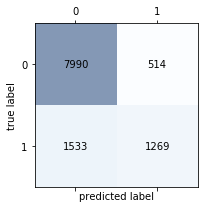

('ACC: ', 0.818945692552627)
('SEN: ', 0.45289079229122053)
('ESP: ', 0.9395578551269991)
('PPV: ', 0.7117218171620864)
('FSC: ', 0.5535441657579062)


In [17]:
y_pred_test = lr.predict(Xs_test)

confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()

acc = (float(tp)+tn)/(tn+fp+fn+tp)
sen = float(tp)/(tp+fn)
esp = float(tn)/(tn+fp)
ppv = float(tp)/(tp+fp)
fsc = 2.0*(sen*ppv/(sen+ppv))

print('ACC: ', acc)
print('SEN: ', sen)
print('ESP: ', esp)
print('PPV: ', ppv)
print('FSC: ', fsc)

Vemos la calidad del clasificador por último con la curva ROC

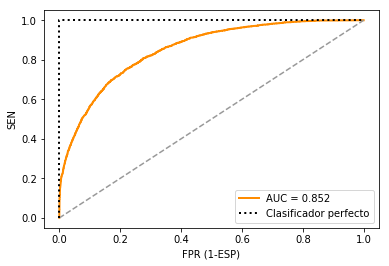

In [18]:
y_prob = lr.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.3f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Se trata de un clasificador aceptable, con una buena curva ROC y buenas métricas de precisión y ESP. Sin embargo, la matriz de confusión muestra un gran número de errores de tipo falso negativo y por lo tanto intentaremos con otro modelo de clasificación.

Vamos a probar con un modelo de árboles de decisión.

In [19]:
treeModel = DecisionTreeClassifier(max_depth=4)
treeModel.fit(X_train, y_train)

y_test_predicted = treeModel.predict(Xs_test)
print(treeModel.score(X_test,y_test))

0.842207677339


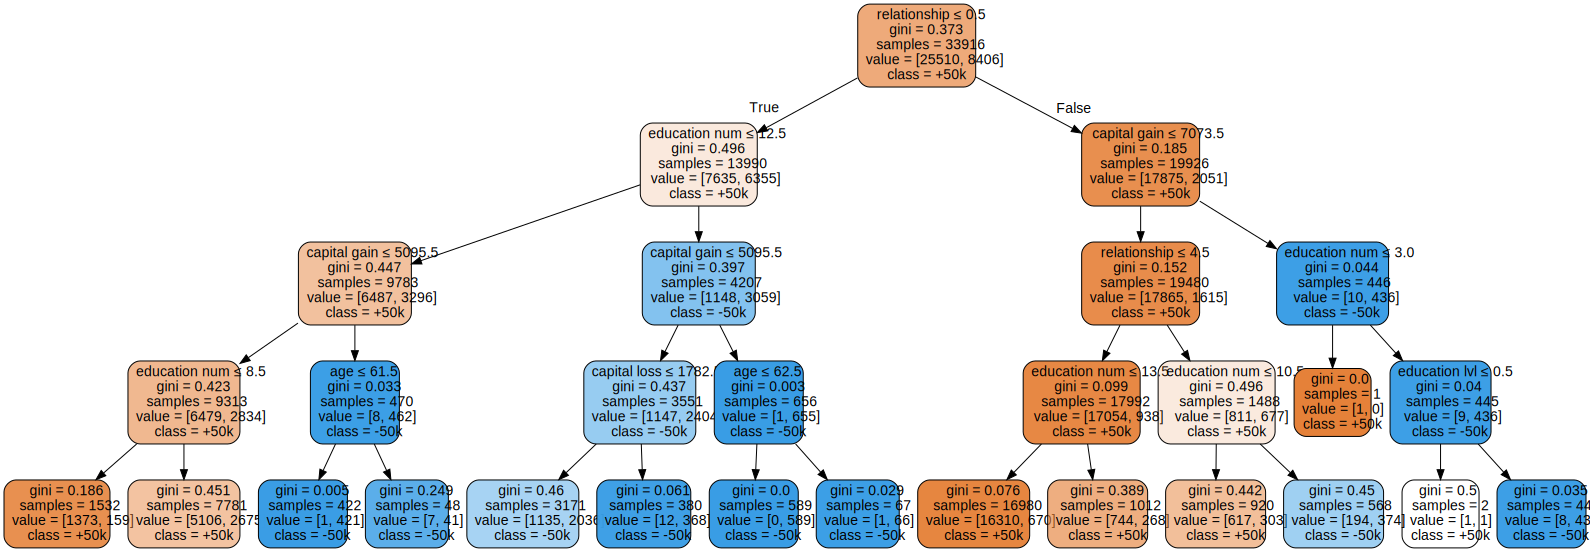

In [20]:
dot_data = tree.export_graphviz(treeModel, out_file=None, 
                         feature_names=['age', 'workclass', 'education lvl', 'education num', 'marital status', 'occupation', 'relationship', 'race', 'sex', 'capital gain', 'capital loss', 'hours/week', 'country'],  
                         class_names=['+50k','-50k'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

Hemos representado el árbol con las muestras sin escalar para que sea más intuitivo recorrer un camino para determinar si una oservación pertenece al grupo mayor de 50.000 o menor de 50.000.

Los valores de gini son algo altos por lo que no es un clasificador muy fiable. Aumentar más la profundidad supondría un árbol demasiado complejo para poder representarlo con graphviz por lo que lo dejaremos así.

Vamos a probar un último modelo para este problema de clasificación, en este caso un modelo SVM. Dada la cantidad de datos utilizaremos un kernel lineal en lugar de un RBF, demasiado costoso computacionalmente.

In [21]:
#vectorC = (0.01,0.1,1,10)

#param_grid = {'C': vectorC}

#grid = GridSearchCV(SVC(kernel='linear'),scoring='accuracy',param_grid=param_grid, cv=5)
#grid.fit(Xs_train,y_train)

#print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
#print("best parameters: {}".format(grid.best_params_))

#scores = grid.cv_results_['mean_test_score']
#plt.semilogx(vectorC,scores,'-o')
#plt.xlabel('C',fontsize=16)
#plt.ylabel('CV ACC')
#plt.show

Incluso con el kernel lineal el problema es demasiado grande para que computacionalmente se llegue a una validación cruzada en un tiempo razonable. Probaremos por tanto con valores de coste arbitrarios.

In [22]:
svm = SVC(kernel='linear', probability=True, C=1).fit(Xs_train,y_train)

print('train: ', svm.score(Xs_train,y_train))
print('test: ', svm.score(Xs_test,y_test))

('train: ', 0.80891024885010021)
('test: ', 0.80523615779232272)


In [23]:
y_pred=svm.predict(Xs_train)
y_pred_test = svm.predict(Xs_test)

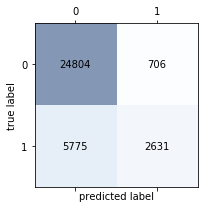

('ACC: ', 0.8089102488501002)
('SEN: ', 0.3129907209136331)
('ESP: ', 0.9723245785966288)
('PPV: ', 0.7884327240035961)
('FSC: ', 0.44809673848250015)


In [24]:
confmat = confusion_matrix(y_train,y_pred)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred).ravel()

accSVM = (float(tp)+tn)/(tn+fp+fn+tp)
senSVM = float(tp)/(tp+fn)
espSVM = float(tn)/(tn+fp)
ppvSVM = float(tp)/(tp+fp)
fscSVM = 2.0*(senSVM*ppvSVM/(senSVM+ppvSVM))

print('ACC: ', accSVM)
print('SEN: ', senSVM)
print('ESP: ', espSVM)
print('PPV: ', ppvSVM)
print('FSC: ', fscSVM)

Probamos ahora con test para comprobar que da resultados similares.

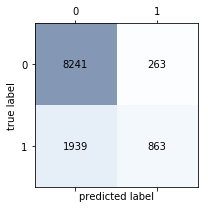

('ACC: ', 0.8052361577923227)
('SEN: ', 0.30799428979300497)
('ESP: ', 0.9690733772342427)
('PPV: ', 0.7664298401420959)
('FSC: ', 0.43940936863543784)


In [25]:
confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()

acc = (float(tp)+tn)/(tn+fp+fn+tp)
sen = float(tp)/(tp+fn)
esp = float(tn)/(tn+fp)
ppv = float(tp)/(tp+fp)
fsc = 2.0*(sen*ppv/(sen+ppv))

print('ACC: ', acc)
print('SEN: ', sen)
print('ESP: ', esp)
print('PPV: ', ppv)
print('FSC: ', fsc)

Vemos la calidad del clasificador por último con la curva ROC

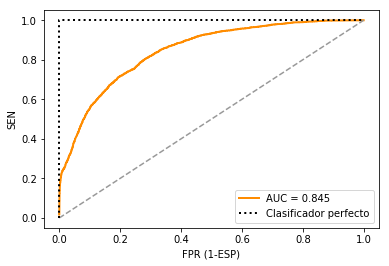

In [26]:
y_prob = svm.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.3f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

El área bajo la curva roc es ligeramente menor en este caso que en el de regresión logística. Veamos una comparativa delas métricas obtenidas en ambos modelos:

Regresión Logística:

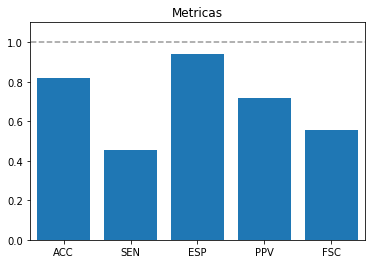

In [27]:
    plt.bar(range(5),[accLR,senLR,espLR,ppvLR,fscLR])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

SVM:

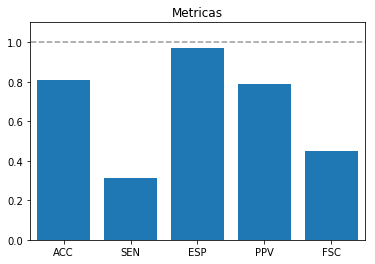

In [28]:
    plt.bar(range(5),[accSVM,senSVM,espSVM,ppvSVM,fscSVM])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

Como conclusión, ambos modelos presentan unas métricas muy similares. El modelo SVM tiene algo mejor ESP y PPV pero menos SEN y FSC.

En cualquier caso, los resultados que arrojan las matrices de confusión de uno y otro modelo son muy similares, compartiendo ambos el problema de los falsos negativos.

Por todo ello, parece que la mejor opción sería quedarse con el modelo más sencillo y que menos coste computacional exige, que en este caso es la regresión logística.

### PROBLEMA 2

Problema de regresión:

    Estimar el precio (price) de un diamante 
    Datos: diamonds.csv

Al igual que en el problema anterior, lo primero es cargar los datos para poder analizarlos (análisis exploratorio)

In [4]:
data2 = pd.read_csv("./diamonds.csv")

print("N, D:",data2.shape)
data2.head(15) 

('N, D:', (53940, 11))


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [15]:
data2.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


A simple vista parece que podemos eliminar la primera columna ('Unnamed:0') dado que es un simple identificador ordinal de cada observación y no es una característica que vaya a ayudar en el modelo de regresión.

Además, hay una serie de variables que no son de tipo numérico y por lo tanto deberemos codificarlas

In [19]:
le = LabelEncoder()

data2['cut'] = le.fit_transform(data2['cut'])
data2['color'] = le.fit_transform(data2['color'])
data2['clarity'] = le.fit_transform(data2['clarity'])

data2 = data2.drop(['Unnamed: 0'],axis=1)

data2.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


Vamos a representar cada variable frente a la variable target para ver si podemos sacar conclusiones. A continuación estuadiaremos la correlación entre las características. A priori parece que existira una fuerte correlación entre la variable depth y las dimensiones x, y, x dado que depende directamente de éstas.

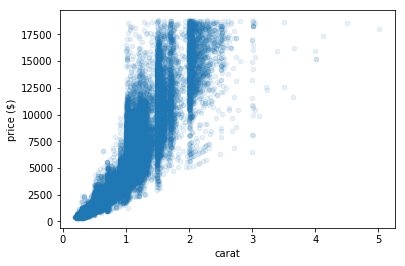

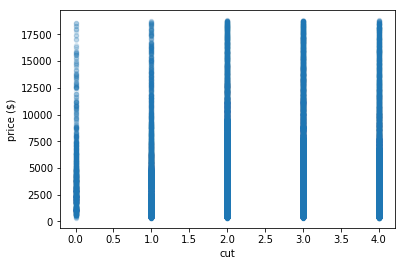

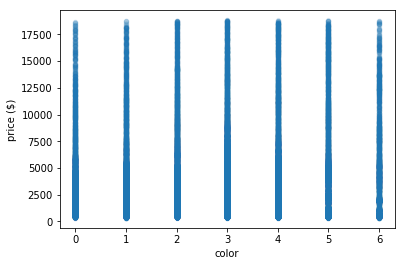

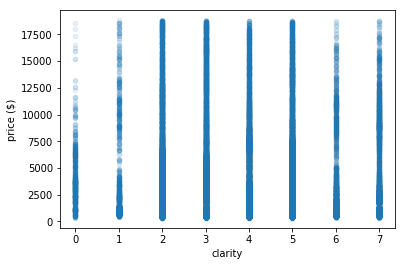

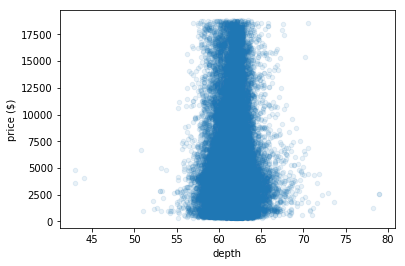

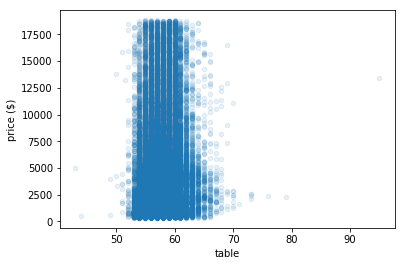

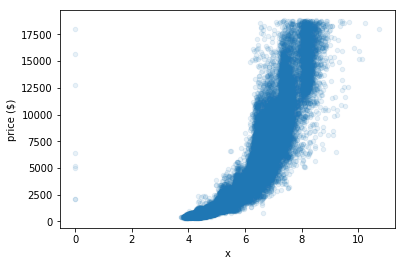

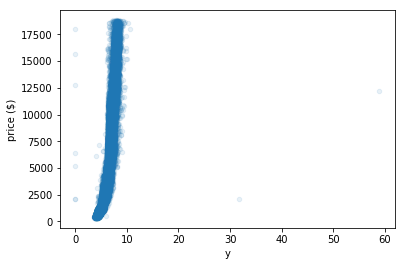

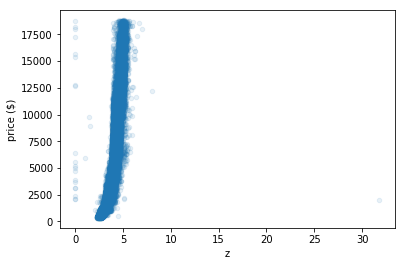

In [29]:

data2.plot(kind = 'scatter',x='carat',y = 'price',alpha=0.1)
plt.xlabel('carat')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='cut',y = 'price',alpha=0.1)
plt.xlabel('cut')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='color',y = 'price',alpha=0.1)
plt.xlabel('color')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='clarity',y = 'price',alpha=0.1)
plt.xlabel('clarity')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='depth',y = 'price',alpha=0.1)
plt.xlabel('depth')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='table',y = 'price',alpha=0.1)
plt.xlabel('table')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='x',y = 'price',alpha=0.1)
plt.xlabel('x')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='y',y = 'price',alpha=0.1)
plt.xlabel('y')
plt.ylabel('price ($)')
plt.show()

data2.plot(kind = 'scatter',x='z',y = 'price',alpha=0.1)
plt.xlabel('z')
plt.ylabel('price ($)')
plt.show()

plt.show()

Parece que hay una relación clara entre el peso del diamante y su precio. En el caso de corte, color y claridad no parece existir una relación, existindo todo el rango de precios para cualquiera de los valores definidos de estas variables.

Lo miso ocurre entre con las variables depth y table, aunque con valores continuos en este caso.

En cuanto a las variables de dimensión existe algo de relación, siendo la más marcada la de la dimensión x.

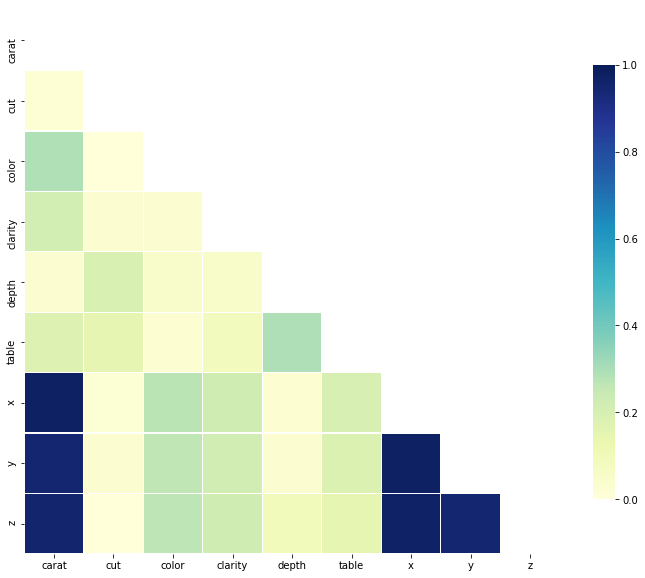

In [30]:
# Compute the correlation matrix
corr = np.abs(data2.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Podemos observar que las variables dimensionales no estan correladas con la variable 'table' como era nuestra hipótesis, pero sí que estan muy correladas entre ellas y además con la variable 'carat' (peso del diamante).

Dados estos resultados, nos quedaremos con la variable 'carat' como característica relevante en lo relativo al volumen del diamante (relacionado con el peso mediante la densidad) y eliminamos las características x, y, z.

In [35]:
data2 = data2.drop(['x','y','z'],axis=1)

data2.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,2,1,3,61.5,55.0,326
1,0.21,3,1,2,59.8,61.0,326
2,0.23,1,1,4,56.9,65.0,327
3,0.29,3,5,5,62.4,58.0,334
4,0.31,1,6,3,63.3,58.0,335


Ya tenemos los datos preparados para entrenar un modelo de regresión que nos permita estimar el precio de un diamante dadas sus características.

Vamos a probar en primer lugar con un método embedded utilizando Lasso para dar coeficientes a cada una de las características y anular las menos relevantes.

In [36]:
# convertimos el DataFrame al formato necesario para scikit-learn
dataM2 = data2.as_matrix() 

y = dataM2[:,6]
X = dataM2[:,:6]   

feature_names = data2.columns[:6]

In [40]:
# Dividimos los datos en entrenamiento y test (75 training, 25 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 0)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train->tb al test la misma transformacion)
#scaler = preprocessing.StandardScaler().fit(X_train)
#XtrainScaled = scaler.transform(X_train)
#XtestScaled = scaler.transform(X_test)

('Datos entrenamiento: ', (40455, 6))
('Datos test: ', (13485, 6))


best mean cross-validation score: -1909887.395
best parameters: {'alpha': 0.10000000000000001}


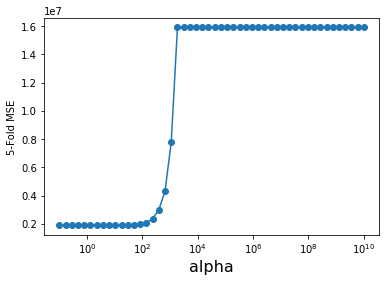

In [87]:
alpha_vector = np.logspace(-1,10,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [88]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
ytestLasso  = lasso.predict(X_test)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.91e+06
MSE Modelo Lasso (test) : 1.89e+06
('carat', 8336.011553257591)
('cut', 75.326151338211758)
('color', -255.88139901701732)
('clarity', 301.32283933973872)
('depth', -107.95772747153208)
('table', -97.628730290670575)


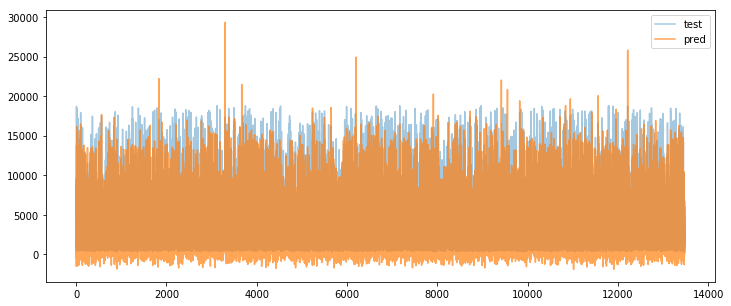

In [89]:
plt.figure(figsize=(12,5))

plt.plot(y_test,label='test', alpha=0.4)
plt.plot(ytestLasso,label='pred', alpha=0.7)
plt.legend()
plt.show()

El error es grande con este modelo y como puede verse en la representación, tiende a estimar un precio menor que el real en términos generales.

Probamos a continuación con árbol de regresión y random forest.

best mean cross-validation score: 0.975
best parameters: {'max_depth': 11}


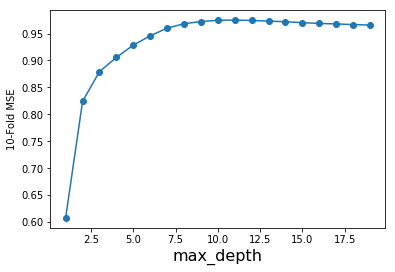

In [72]:
maxDepth = range(1,20)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')

plt.show()

In [73]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

('Train: ', 0.98416760080883725)
('Test: ', 0.97504505541969799)


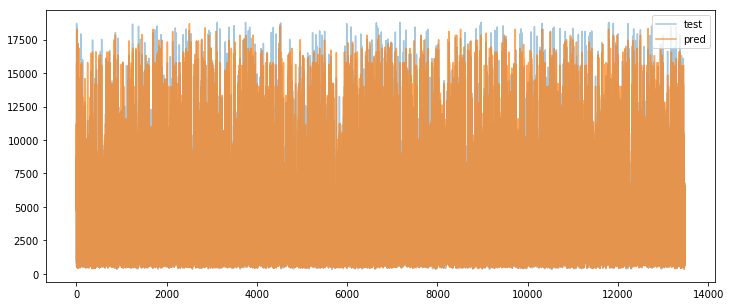

In [83]:
ytestTree = treeModel.predict(X_test)

plt.figure(figsize=(12,5))

plt.plot(y_test,label='test',alpha=0.4)
plt.plot(ytestTree,label='pred',alpha=0.7)
plt.legend()
plt.show()

En este modelo el error es bajísimo tal y como podemos ver por la puntuación (.score). La gráfica nos permite ver a simple vista como el precio que predice el modelo se ajusta muy bien al real para el conjunto de test, a diferencia del modelo anterior.

Probamos random forest a pesar de que el resultado ya es muy bueno.

best mean cross-validation score: 0.976
best parameters: {'max_depth': 19}


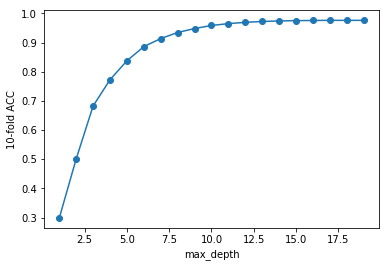

In [84]:
# grid search
maxDepth = range(1,20)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [85]:
maxDepthOptimo = grid.best_params_['max_depth']
rfModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",rfModel.score(X_train,y_train))
print("Test: ",rfModel.score(X_test,y_test))

('Train: ', 0.99539474341379253)
('Test: ', 0.97785362967255207)


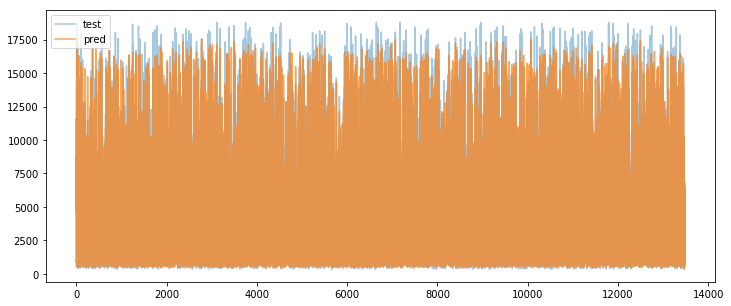

In [86]:
ytestRF = rfModel.predict(X_test)

plt.figure(figsize=(12,5))

plt.plot(y_test,label='test',alpha=0.4)
plt.plot(ytestRF,label='pred',alpha=0.7)
plt.legend()
plt.show()

El resultado es muy similar al de árbol de regresión, más uniforme y con un .score ligeramente superior. En la gráfica se ve como la predicción se adapta muy bien al precio de las muestras de test si bien las valora un poco por debajo de su precio.

En cualquier caso, y al igual que en el ejercicio número 1, parece mejor quedarse con el modelo más simple ante unos resultados tan parecidos. Por ello el modelo elegido sería el de árbol de regresión.